# A primer on calculating rotational and divergent wind components

<div class="alert alert-warning" role="alert"><a href=https://ajdawson.github.io/windspharm/latest/>This example requires windspharm installed.</a></div>

You can install it using `conda` (in the correct environment):
```bash
!conda install -c conda-forge windspharm --yes
```

In [1]:
from pathlib import Path

import iris
from aeolus.calc import wind_rot_div
from aeolus.core import AtmoSim
from aeolus.model import um

## Loading data

In [2]:
sample_file = (
    Path.cwd().parent / "tests" / "data" / "test_data" / "netcdf" / "ch111_ctrl_mean_u_v_w.nc"
)

In [3]:
inp_data = iris.load(sample_file)

In [4]:
print(inp_data)

0: upward_air_velocity / (m s-1)       (level_height: 39; latitude: 90; longitude: 144)
1: x_wind / (m s-1)                    (level_height: 39; latitude: 90; longitude: 144)
2: y_wind / (m s-1)                    (level_height: 39; latitude: 90; longitude: 144)


**Note** that the x- and y-wind components are already [horizontally interpolated](https://scitools-iris.readthedocs.io/en/latest/userguide/interpolation_and_regridding.html#regridding) to the same grid.

The `inp_data` cube list can be then used to instantiate an `AtmoSim` object, using a planet configuration with relevant constants (see "Physical constants" example for more info).

In [5]:
my_run = AtmoSim(
    cubes=inp_data,
    name="t1e",
    description="Time-mean output from a UM simulation of the THAI Hab 1 case.",
    planet="trap1e",  # this reads constants from a JSON file
)

## Applying Helmoltz decomposition

For convenience, let's select a single level in the vertical. This is optional - the rot/div decomposition can be performed on an N-dimensional cubes, as long as they have longitude and latitude dimensions.

In [6]:
u_at_8km = my_run.u.extract(iris.Constraint(**{um.z: 8000}))
v_at_8km = my_run.v.extract(iris.Constraint(**{um.z: 8000}))

Check that the data is indeed roughly at 8000 m height.

In [7]:
print(u_at_8km.coord(um.z))

DimCoord :  level_height / (m)
    points: [7988.824]
    bounds: [[7438.572, 8579.836]]
    shape: (1,)  bounds(1, 2)
    dtype: float64
    long_name: 'level_height'
    var_name: 'level_height'
    attributes:
        positive  'up'


We can then apply the rot/div decomposition. The planet's radius will be taken from the cubes' metadata. Alternatively, it can be supplied by passing a `ConstContainer` as the `const` optional argument to the `wind_rot_div()` function.

In [8]:
rot_div_cubes = wind_rot_div(u_at_8km, v_at_8km)

In [9]:
rot_div_cubes

{'u_total': <iris 'Cube' of x_wind / (m s-1) (latitude: 90; longitude: 144)>,
 'v_total': <iris 'Cube' of y_wind / (m s-1) (latitude: 90; longitude: 144)>,
 'u_div': <iris 'Cube' of irrotational_eastward_wind / (m s**-1) (latitude: 90; longitude: 144)>,
 'v_div': <iris 'Cube' of irrotational_northward_wind / (m s**-1) (latitude: 90; longitude: 144)>,
 'u_rot': <iris 'Cube' of non_divergent_eastward_wind / (m s**-1) (latitude: 90; longitude: 144)>,
 'v_rot': <iris 'Cube' of non_divergent_northward_wind / (m s**-1) (latitude: 90; longitude: 144)>,
 'u_rot_zm': <iris 'Cube' of zonal_mean_of_non_divergent_eastward_wind / (m s**-1) (latitude: 90; longitude: 144)>,
 'u_rot_eddy': <iris 'Cube' of zonal_deviation_of_non_divergent_eastward_wind / (m s**-1) (latitude: 90; longitude: 144)>,
 'v_rot_zm': <iris 'Cube' of zonal_mean_of_non_divergent_northward_wind / (m s**-1) (latitude: 90; longitude: 144)>,
 'v_rot_eddy': <iris 'Cube' of zonal_deviation_of_non_divergent_northward_wind / (m s**-1) (

## Visualise the rot/div components

In [10]:
import matplotlib.pyplot as plt
from aeolus.plot import subplot_label_generator

To visualise the results, let's create a dictionary with all the relevant metadata.

In [11]:
WIND_CMPNT_META = {
    "total": {"title": "Total", "qk_ref_wspd": 60, "kw_plt": {"color": "#222222"}},
    "div": {"title": "Divergent", "qk_ref_wspd": 10, "kw_plt": {"color": "C0"}},
    "rot_zm": {"title": "Jet", "qk_ref_wspd": 60, "kw_plt": {"color": "C3"}},
    "rot_eddy": {"title": "Eddy", "qk_ref_wspd": 30, "kw_plt": {"color": "C2"}},
}

Because all longitudes and latitudes are the same in this example, we can get the data points for these coordinates right away and then use them for plotting.

In [12]:
lons = my_run.coord.x.points
lats = my_run.coord.y.points

# Equivalent to
# lons = u_at_8km.coord("longitude").points
# lats = u_at_8km.coord("latitude").points

We then define slices along the longitude and latitude axes to show every 8th and 6th quiver, respectively.

In [13]:
xstride = 8
ystride = 6
xsl = slice(None, None, xstride)
ysl = slice(None, None, ystride)

Assemble the figure and plot all the relevant components (following Hammond & Lewis, 2021).

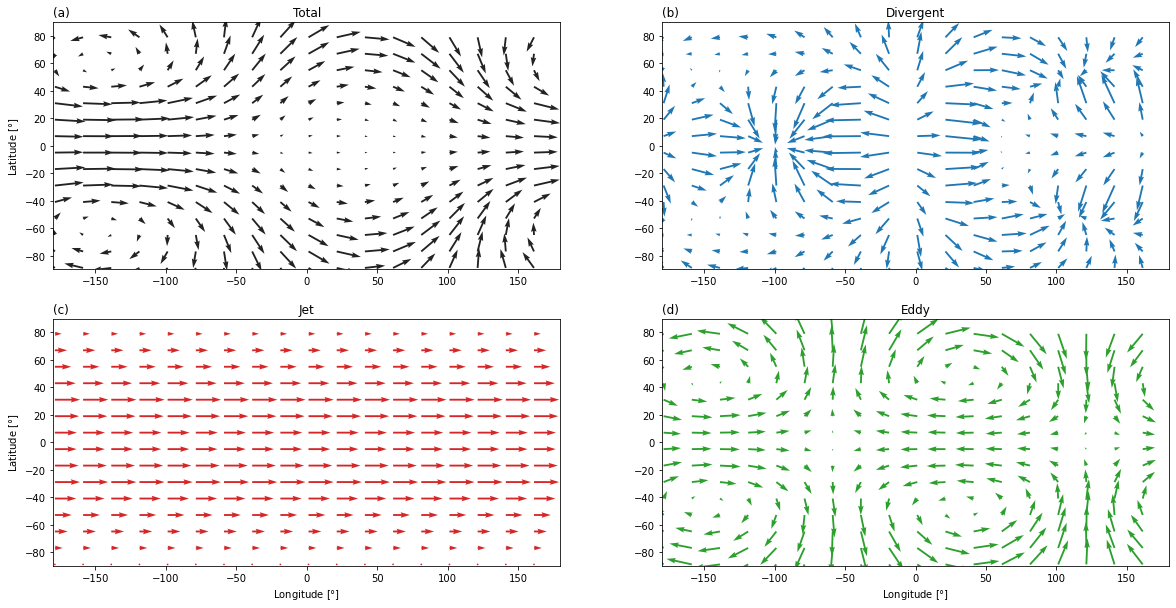

In [14]:
fig = plt.figure(figsize=(20, 10))

mosaic = [[*WIND_CMPNT_META.keys()][:2], [*WIND_CMPNT_META.keys()][2:]]

axd = fig.subplot_mosaic(mosaic)
iletters = subplot_label_generator()
for wind_key, wind_meta in WIND_CMPNT_META.items():
    ax = axd[wind_key]
    ax.set_title(f"({next(iletters)})", loc="left")
    ax.set_title(wind_meta["title"], loc="center")
    ax.set_ylim(-90, 90)
    ax.set_xlim(-180, 180)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]")

    _u_cmpnt = rot_div_cubes[f"u_{wind_key}"].data
    _v_cmpnt = rot_div_cubes[f"v_{wind_key}"].data

    ax.quiver(lons[xsl], lats[ysl], _u_cmpnt[ysl, xsl], _v_cmpnt[ysl, xsl], **wind_meta["kw_plt"])

The end.